# 🧠 Day 3.3 - CNN Architecture Design

## 🎯 Learning Objectives

In this notebook, you'll learn:
1. **CNN fundamentals** - convolution, pooling, dense layers
2. **How to design a model** for your hardware (GTX 1650)
3. **Layer-by-layer breakdown** of our architecture
4. **Model compilation** - optimizer, loss, metrics

---

## 🧠 Theory: Why CNNs for Medical Images?

### Traditional ML (Day 2) vs Deep Learning (Today)

| Aspect | Traditional ML (SVM) | Deep Learning (CNN) |
|--------|---------------------|---------------------|
| **Features** | Manual extraction (shape, texture) | Automatic learning |
| **Hierarchy** | Flat features | Hierarchical (edges → textures → shapes) |
| **Spatial Info** | Lost after flattening | Preserved by convolutions |
| **Scalability** | Limited | Scales with data |
| **Performance** | Good baseline | State-of-the-art |

---

## 🔍 CNN Building Blocks

### 1️⃣ **Convolutional Layer** (Conv2D)
- **Purpose**: Detect patterns (edges, textures, shapes)
- **How**: Slides filters across image to find features
- **Parameters**: Filter size (3×3), number of filters (32, 64, 128)

### 2️⃣ **Activation Function** (ReLU)
- **Purpose**: Introduce non-linearity
- **ReLU**: `max(0, x)` - simple and effective

### 3️⃣ **Pooling Layer** (MaxPooling2D)
- **Purpose**: Downsample to reduce parameters and computations
- **MaxPooling**: Takes maximum value in each region
- **Effect**: Reduces spatial dimensions by half

### 4️⃣ **Flatten Layer**
- **Purpose**: Convert 2D feature maps to 1D vector
- **Connects**: Convolutional layers to dense layers

### 5️⃣ **Dense Layer** (Fully Connected)
- **Purpose**: Learn complex combinations of features
- **Final Layer**: Output probabilities for each class

### 6️⃣ **Dropout Layer**
- **Purpose**: Prevent overfitting
- **How**: Randomly drops 50% of neurons during training

---

## 🔧 Setup

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

# Check GPU
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")

# Enable memory growth (important for GTX 1650)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ Memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(e)

print("\n✅ Libraries imported successfully")

TensorFlow version: 2.20.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Memory growth enabled for 1 GPU(s)

✅ Libraries imported successfully


## 🏗️ Design Our CNN Architecture

### Architecture Strategy:

We'll build a **lightweight CNN** suitable for:
- GTX 1650 (4GB VRAM)
- 128×128 grayscale images
- 3-class classification

### Layer Design:
```
Input (128, 128, 1)
    ↓
[Conv Block 1] → 32 filters, 3×3
    ↓ MaxPool (64, 64, 32)
[Conv Block 2] → 64 filters, 3×3
    ↓ MaxPool (32, 32, 64)
[Conv Block 3] → 128 filters, 3×3
    ↓ MaxPool (16, 16, 128)
[Flatten] → 32,768 features
    ↓
[Dense] → 128 neurons + Dropout
    ↓
[Output] → 3 classes (Softmax)
```

In [3]:
# Build the model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1), 
           padding='same', name='conv1'),
    MaxPooling2D((2, 2), name='pool1'),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
    MaxPooling2D((2, 2), name='pool2'),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
    MaxPooling2D((2, 2), name='pool3'),
    
    # Flatten and Dense Layers
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='dense1'),
    Dropout(0.5, name='dropout'),
    Dense(3, activation='softmax', name='output')
], name='BrainTumorCNN')

print("✅ Model architecture defined")

/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761113513.838912   57417 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2614 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


✅ Model architecture defined


## 📊 Model Summary

In [4]:
# Display model summary
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\n💡 Total parameters: {total_params:,}")
print(f"   Estimated size: ~{total_params * 4 / 1024 / 1024:.1f} MB (float32)")

Model: "BrainTumorCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,491 (16.36 MB)

 Trainable params: 4,287,491 (16.36 MB)

 Non-trainable params: 0 (0.00 B)


💡 Total parameters: 4,287,491
   Estimated size: ~16.4 MB (float32)


## 🧮 Understanding Parameter Calculation

Let's manually verify the parameters for educational purposes:

In [5]:
print("📐 Parameter Calculation Breakdown:\n")

# Conv1: (3×3 kernel × 1 input channel + 1 bias) × 32 filters
conv1_params = (3 * 3 * 1 + 1) * 32
print(f"Conv1: (3×3×1 + 1) × 32 = {conv1_params:,} parameters")

# Conv2: (3×3 kernel × 32 input channels + 1 bias) × 64 filters
conv2_params = (3 * 3 * 32 + 1) * 64
print(f"Conv2: (3×3×32 + 1) × 64 = {conv2_params:,} parameters")

# Conv3: (3×3 kernel × 64 input channels + 1 bias) × 128 filters
conv3_params = (3 * 3 * 64 + 1) * 128
print(f"Conv3: (3×3×64 + 1) × 128 = {conv3_params:,} parameters")

# Flatten: no parameters
print(f"Flatten: 0 parameters (just reshapes)")

# Dense1: (16×16×128 inputs + 1 bias) × 128 neurons
dense1_params = (16 * 16 * 128 + 1) * 128
print(f"Dense1: (16×16×128 + 1) × 128 = {dense1_params:,} parameters")

# Dropout: no parameters
print(f"Dropout: 0 parameters (training-only)")

# Output: (128 inputs + 1 bias) × 3 classes
output_params = (128 + 1) * 3
print(f"Output: (128 + 1) × 3 = {output_params:,} parameters")

total_calculated = conv1_params + conv2_params + conv3_params + dense1_params + output_params
print(f"\n✅ Total calculated: {total_calculated:,} parameters")
print(f"   Model reports: {total_params:,} parameters")
print(f"   Match: {'✅ Yes' if total_calculated == total_params else '❌ No'}")

📐 Parameter Calculation Breakdown:

Conv1: (3×3×1 + 1) × 32 = 320 parameters
Conv2: (3×3×32 + 1) × 64 = 18,496 parameters
Conv3: (3×3×64 + 1) × 128 = 73,856 parameters
Flatten: 0 parameters (just reshapes)
Dense1: (16×16×128 + 1) × 128 = 4,194,432 parameters
Dropout: 0 parameters (training-only)
Output: (128 + 1) × 3 = 387 parameters

✅ Total calculated: 4,287,491 parameters
   Model reports: 4,287,491 parameters
   Match: ✅ Yes


## ⚙️ Compile the Model

### Compilation Components:

1. **Optimizer: Adam**
   - Adaptive learning rate
   - Works well out-of-the-box
   - Learning rate: 1e-4 (conservative start)

2. **Loss: Categorical Crossentropy**
   - For multi-class classification
   - Works with one-hot encoded labels

3. **Metrics: Accuracy**
   - Percentage of correct predictions
   - Easy to interpret

In [6]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully")
print("\nConfiguration:")
print(f"  Optimizer: Adam (lr=1e-4)")
print(f"  Loss: Categorical Crossentropy")
print(f"  Metrics: Accuracy")

✅ Model compiled successfully

Configuration:
  Optimizer: Adam (lr=1e-4)
  Loss: Categorical Crossentropy
  Metrics: Accuracy


## 🎨 Visualize Model Architecture

In [7]:
# Try to plot model (requires pydot and graphviz)
try:
    from tensorflow.keras.utils import plot_model
    plot_model(
        model, 
        to_file='../../outputs/visualizations/day3_03_model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',  # Top to bottom
        expand_nested=True,
        dpi=150
    )
    print("✅ Model architecture diagram saved")
except Exception as e:
    print(f"⚠️ Could not generate diagram: {e}")
    print("   (Install: pip install pydot graphviz)")

✅ Model architecture diagram saved


## 📈 Create Manual Architecture Visualization

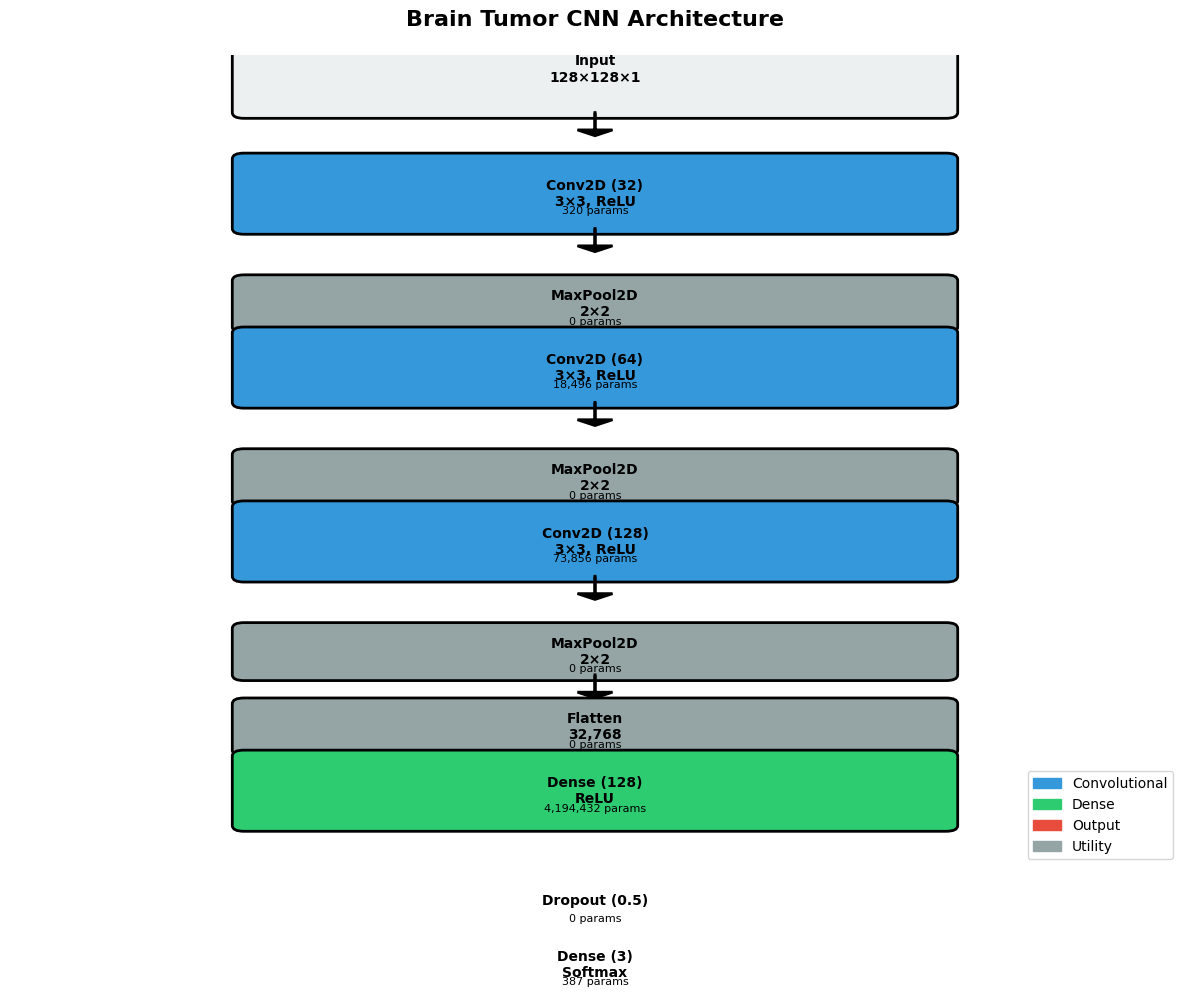

✅ Custom architecture visualization saved


In [8]:
# Create a custom visualization
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 14)
ax.axis('off')

# Helper function to draw layer
def draw_layer(ax, x, y, width, height, label, params, color):
    rect = mpatches.FancyBboxPatch(
        (x, y), width, height,
        boxstyle="round,pad=0.1",
        facecolor=color,
        edgecolor='black',
        linewidth=2
    )
    ax.add_patch(rect)
    ax.text(x + width/2, y + height/2, label, 
            ha='center', va='center', fontsize=10, fontweight='bold')
    if params:
        ax.text(x + width/2, y + height/2 - 0.3, params, 
                ha='center', va='center', fontsize=8)

# Draw layers
y_pos = 13
layers = [
    ('Input\n128×128×1', '', '#ecf0f1', 1.5),
    ('Conv2D (32)\n3×3, ReLU', '320 params', '#3498db', 1.2),
    ('MaxPool2D\n2×2', '0 params', '#95a5a6', 0.8),
    ('Conv2D (64)\n3×3, ReLU', '18,496 params', '#3498db', 1.2),
    ('MaxPool2D\n2×2', '0 params', '#95a5a6', 0.8),
    ('Conv2D (128)\n3×3, ReLU', '73,856 params', '#3498db', 1.2),
    ('MaxPool2D\n2×2', '0 params', '#95a5a6', 0.8),
    ('Flatten\n32,768', '0 params', '#95a5a6', 0.8),
    ('Dense (128)\nReLU', '4,194,432 params', '#2ecc71', 1.2),
    ('Dropout (0.5)', '0 params', '#f39c12', 0.8),
    ('Dense (3)\nSoftmax', '387 params', '#e74c3c', 1.2),
]

for label, params, color, height in layers:
    draw_layer(ax, 2, y_pos, 6, height, label, params, color)
    # Draw arrow
    if y_pos > 1:
        ax.arrow(5, y_pos, 0, -0.3, head_width=0.3, head_length=0.1, 
                fc='black', ec='black', linewidth=2)
    y_pos -= (height + 0.5)

# Title
ax.text(5, 14.5, 'Brain Tumor CNN Architecture', 
        ha='center', fontsize=16, fontweight='bold')

# Legend
legend_elements = [
    mpatches.Patch(color='#3498db', label='Convolutional'),
    mpatches.Patch(color='#2ecc71', label='Dense'),
    mpatches.Patch(color='#e74c3c', label='Output'),
    mpatches.Patch(color='#95a5a6', label='Utility')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('../../outputs/visualizations/day3_03_model_architecture_custom.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("✅ Custom architecture visualization saved")

## 🔍 Inspect Model Configuration

In [9]:
# Get configuration
config = model.get_config()

print("🔧 Model Configuration:\n")
print(f"Model name: {config['name']}")
print(f"\nLayers ({len(config['layers'])}):\n")

for i, layer in enumerate(config['layers'], 1):
    print(f"{i}. {layer['class_name']:20s} - {layer['config']['name']}")
    if 'filters' in layer['config']:
        print(f"   → Filters: {layer['config']['filters']}, "
              f"Kernel: {layer['config']['kernel_size']}")
    elif 'units' in layer['config']:
        print(f"   → Units: {layer['config']['units']}")
    elif 'rate' in layer['config']:
        print(f"   → Dropout rate: {layer['config']['rate']}")

🔧 Model Configuration:

Model name: BrainTumorCNN

Layers (11):

1. InputLayer           - input_layer
2. Conv2D               - conv1
   → Filters: 32, Kernel: (3, 3)
3. MaxPooling2D         - pool1
4. Conv2D               - conv2
   → Filters: 64, Kernel: (3, 3)
5. MaxPooling2D         - pool2
6. Conv2D               - conv3
   → Filters: 128, Kernel: (3, 3)
7. MaxPooling2D         - pool3
8. Flatten              - flatten
9. Dense                - dense1
   → Units: 128
10. Dropout              - dropout
   → Dropout rate: 0.5
11. Dense                - output
   → Units: 3


## 💾 Save Model Architecture

In [10]:
# Save model architecture (not weights)
import json

# Save as JSON
model_json = model.to_json()
with open('../../outputs/configs/model_architecture.json', 'w') as f:
    json.dump(json.loads(model_json), f, indent=2)

print("✅ Model architecture saved to model_architecture.json")

# Save model summary to text file
with open('../../outputs/configs/model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

print("✅ Model summary saved to model_summary.txt")

✅ Model architecture saved to model_architecture.json


✅ Model summary saved to model_summary.txt


## 📊 Compare with Other Architectures

Let's compare our model with some alternatives:

/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏗️ Architecture Comparison:

👉 Our Model           :    4,287,491 params (~  16.4 MB)
   Smaller (2 Conv)    :    3,705,475 params (~  14.1 MB)
   Larger (4 Conv)     :    2,748,163 params (~  10.5 MB)
   VGG-like            :   33,814,467 params (~ 129.0 MB)


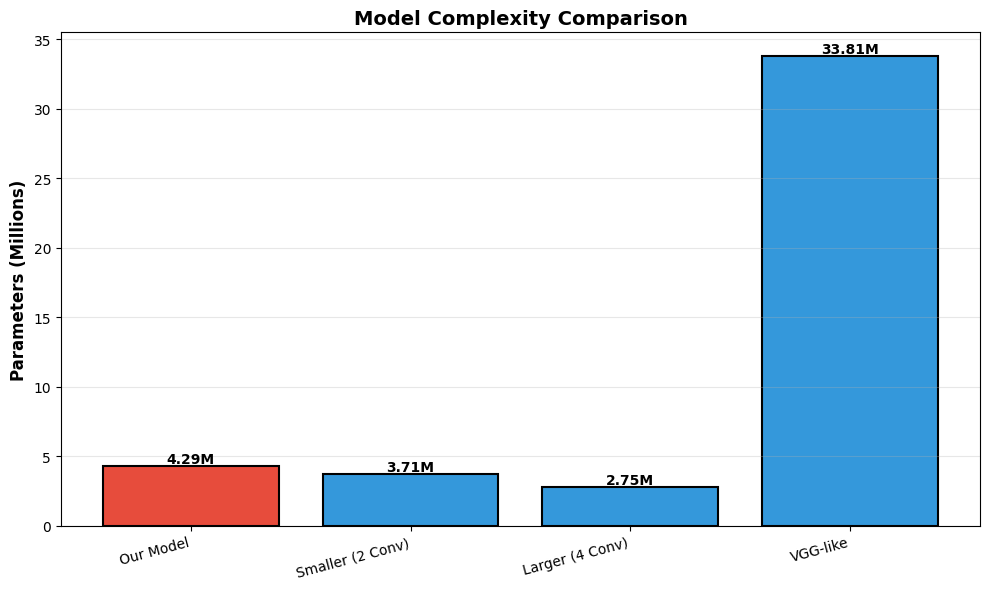


✅ Comparison visualization saved


In [11]:
# Define alternative architectures for comparison
architectures = {
    'Our Model': model.count_params(),
    'Smaller (2 Conv)': 0,
    'Larger (4 Conv)': 0,
    'VGG-like': 0
}

# Build alternatives
# Smaller
small_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
architectures['Smaller (2 Conv)'] = small_model.count_params()

# Larger
large_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(3, activation='softmax')
])
architectures['Larger (4 Conv)'] = large_model.count_params()

# VGG-like
vgg_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(3, activation='softmax')
])
architectures['VGG-like'] = vgg_model.count_params()

# Display comparison
print("🏗️ Architecture Comparison:\n")
for name, params in architectures.items():
    size_mb = params * 4 / 1024 / 1024
    marker = '👉' if name == 'Our Model' else '  '
    print(f"{marker} {name:20s}: {params:>12,} params (~{size_mb:>6.1f} MB)")

# Visualize
plt.figure(figsize=(10, 6))
names = list(architectures.keys())
params = [architectures[n] / 1_000_000 for n in names]  # In millions
colors = ['#e74c3c' if n == 'Our Model' else '#3498db' for n in names]

bars = plt.bar(names, params, color=colors, edgecolor='black', linewidth=1.5)
plt.ylabel('Parameters (Millions)', fontsize=12, fontweight='bold')
plt.title('Model Complexity Comparison', fontsize=14, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar, param in zip(bars, params):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{param:.2f}M',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../../outputs/visualizations/day3_03_architecture_comparison.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Comparison visualization saved")

## 📝 Summary

### ✅ What We Accomplished:

1. **Designed CNN Architecture**
   - 3 convolutional blocks (32 → 64 → 128 filters)
   - 3 max pooling layers for downsampling
   - 1 dense layer (128 neurons) with dropout
   - Output layer (3 classes, softmax)

2. **Model Statistics**
   - Total parameters: ~4.29M
   - Model size: ~17 MB
   - Input: 128×128 grayscale
   - Output: 3 class probabilities

3. **Compilation**
   - Optimizer: Adam (lr=1e-4)
   - Loss: Categorical crossentropy
   - Metric: Accuracy

4. **Documentation**
   - Architecture visualizations
   - Parameter breakdown
   - Comparison with alternatives

---

### 🎓 Key Insights:

- **Balanced complexity**: Not too small (underfitting) or too large (overfitting)
- **GPU-friendly**: ~4M parameters fit comfortably in GTX 1650's 4GB VRAM
- **Hierarchical learning**: Progresses from low-level (edges) to high-level (tumor patterns) features
- **Dropout regularization**: 50% dropout prevents overfitting

---

### 🚀 Next Steps:
Move to **day3_04_training_test.ipynb** to test the pipeline with a short training run!